In [2]:
# Calculate logprob for specific values.
import os
os.environ["KERAS_BACKEND"] = "jax"  # Must be specified before loading keras_core
os.environ["JAX_PLATFORM_NAME"] = "cpu" # CPU is faster for batchsize=1 inference.
import numpy as np
import pandas as pd
import keras_core as keras
import jax
import jax.numpy as jnp
from jax import random, vmap, jit, grad
#assert jax.default_backend() == 'gpu'
import sys
sys.path.append('../')
import utils
import time
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
#import elegy # pip install elegy. # Trying to do this with keras core instead.
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

from preprocess.preprocess import transform_input, untransform_input

def define_log_prob(model_path, data_path, parameters_specified, penalty=1e9):
    """
    Args:
        model_path: filename of model
        data_path: filename of experimental data for interval, e.g. path/AMS02_H-PRL2018_20110520-20110610.dat
        parameters_specified: tuple of alpha, cmf, vspoles.
        penalty = scalar to punish drifting outside zone of interest. 
    """
    # Load trained NN model that maps 7 parameters to predicted flux at RIGIDITY_VALS.
    model = keras.models.load_model(model_path)
    model.run_eagerly = True # Settable attribute (in elegy). Required to be true for ppmodel.

    # Load observation data from Claudio
    #xloc, iloc, observed, uncertainty = utils.load_preprocessed_data_ams(data_path)
    parameters_specified_transformed = transform_input(jnp.array(parameters_specified))
    
    bins, observed, uncertainty = utils.load_data_ams(data_path)
    #bin_midpoints = (bins[:-1] + bins[1:])/2
    bin_midpoints = (bins[:-1] * bins[1:]) ** 0.5


    def nn_predict(x):
        """
        Predict fluxes (untransformed) from transformed input. 
        """
        yhat = model(x)    
        yhat = utils.untransform_output(yhat) # Undo scaling and minmax.
        return yhat

    def target_log_prob(xs):
        """
        Compute log likilihood of parameters given some data.
        Args:
            xs: 1d array containing parameters (transformed to be in range 0--1).
        Returns:
            log_prob: Scalar valued log probability
        """
        # Include logprior in loglikelihood. This keeps HMC from going off into no-mans land.
        nlogprior = 0.
        # for i in range(5):
        #     nlogprior += penalty * jnp.abs((jnp.minimum(0., xs[i]))) # Penalty for being <0
        #     nlogprior += penalty * jnp.abs((jnp.maximum(1., xs[i]) - 1.))  # Penalty for being >1

        batch = utils._form_batch(xs, parameters_specified_transformed)
        yhat = model(batch)    
        #yhat = nn_predict(batch)
        yhat = yhat[0,:]  # Remove batch dimension.
        
        # Interpolate to get predicted flux at both lattice and bin points.
        #yloc = jnp.interp(xloc, utils.RIGIDITY_VALS, yhat)
        yhat = jnp.interp(bin_midpoints, utils.RIGIDITY_VALS, yhat)
        yhat = utils.untransform_output(yhat.reshape((1,-1))).reshape(-1) # Undo scaling and minmax.
        predicted = yhat
        chi2 = (((predicted - observed)/uncertainty)**2).sum()
        log_prob = -chi2/2.  - nlogprior
        return log_prob
        # #assert np.isclose(yhat, yloc[iloc[1:]]) 
        # nbins = len(iloc)-1
        # # Integrate over bin regions, and compare to observed to get likelihood.
        # chi2 = 0.0
        # # for i in range(nbins):
        # #     # Integrate over bin by trapezoid method.
        # #     istart, istop = iloc[i], iloc[i+1]
        # #     area = jnp.trapz(y=yloc[istart:(istop+1)], x=xloc[istart:(istop+1)])
        # #     length = (xloc[istop] - xloc[istart])
        # #     predicted = area / length
        # #     # Use equation provided by Claudio for likelihood of bin.
        # #     chi2 += ((predicted - observed[i])/uncertainty[i])**2
        # for i in range(nbins):
        #     # Integrate over bin by trapezoid method.
        #     istart, istop = iloc[i], iloc[i+1]

        #     #predicted = (yloc[istart] + yloc[istop]) / 2
        #     predicted =(yloc[istart] * yloc[istop])**0.5
        #     # length = (xloc[istop] - xloc[istart])
        #     # predicted = predicted / length

        #     # area = jnp.trapz(y=yloc[istart:(istop+1)], x=xloc[istart:(istop+1)])
        #     # length = (xloc[istop] - xloc[istart])
        #     # predicted = area / length

        #     # bin_center = jnp.sqrt(xloc[istart] * xloc[istop])

            
        #     # Use equation provided by Claudio for likelihood of bin.
        #     chi2 += ((predicted - observed[i])/uncertainty[i])**2
        # log_prob = -chi2/2.  - nlogprior
        # return log_prob

    return target_log_prob

# Model specification
version = 'v1.0'
experiment_name = 'AMS02_H-PRL2021'
interval = '20110520-20110610'
polarity = 'neg'
#filename_heliosphere = f'../data/2023/{experiment_name}_heliosphere.dat'

# Load observation data and define logprob. 
#specified_parameters = utils.get_parameters(filename_heliosphere, interval)
data_path = f'../data/oct2022/{experiment_name}/{experiment_name}_{interval}.dat' # This data is the same.
model_path = f'../models/model_{version}_{polarity}.keras'
penalty = 1e6

## From Claudio:
# alpha = 51.49
# cmf = 4.85
# vseq = 400
# vspoles = 632.52
# cpa = 366.2
# pwr1par = 0.94
# pwr2par = 0.85
# pwr1perr = 1.33
# pwr2perr = 0.74

specified_parameters = np.array([51.49, 4.85, 632.52])
samples = np.array([[366.2, 0.94, 0.85, 1.33, 0.74]])
#target_log_prob = utils.define_log_prob(model_path, data_path, specified_parameters, penalty=penalty)
target_log_prob = define_log_prob(model_path, data_path, specified_parameters, penalty=penalty)
#parameters_specified_transformed = transform_input(jnp.array(specified_parameters).reshape((1,-1)))
samples_transformed = transform_input(jnp.array(samples)).reshape((-1))

logprob = target_log_prob(samples_transformed) # Assumes input is array of dim=1
logprob

# xs = utils._form_batch(samples_transformed, specified_parameters_transformed)
# model = keras.models.load_model(model_path)
# predictions_transformed = model.predict(xs, verbose=2)
# predictions = utils.untransform_output(predictions_transformed)
# #np.savetxt(fname=f'{results_dir}/predictions_{SLURM_ARRAY_TASK_ID}_{df.experiment_name}_{df.interval}_{df.polarity}.csv', X=predictions, delimiter=',')
# predictions

Array(-80.06757, dtype=float32)

In [5]:
#imodel,, alpha,, cmf,, cpa, pwr1par pwr1perr, pwr2par pwr2perr, vseq, vspoles,, chi2, logprob
exps = np.array([[0, 0.00, 2.50, 100.00, 0.40, 0.40, 0.40, 0.40, 400.00, 400.00, 3.767e+03, -1.883e+03],
    [1, 0.00, 2.50, 100.00, 0.40, 0.40, 0.40, 0.70, 400.00, 400.00, 1.777e+03, -8.887e+02],
    [2, 0.00, 2.50, 100.00, 0.40, 0.40, 0.40, 1.00, 400.00, 400.00, 1.575e+03, -7.873e+02],
    [3, 0.00, 2.50, 100.00, 0.40, 0.40, 0.40, 1.30, 400.00, 400.00, 2.259e+03, -1.130e+03],
    [4, 0.00, 2.50, 100.00, 0.40, 0.40, 0.40, 1.70, 400.00, 400.00, 3.847e+03, -1.923e+03],
    [5, 0.00, 2.50, 100.00, 0.40, 0.40, 0.40, 2.30, 400.00, 400.00, 7.305e+03, -3.653e+03],
    [6, 0.00, 2.50, 100.00, 0.40, 0.70, 0.40, 0.40, 400.00, 400.00, 3.126e+03, -1.563e+03],
    [7, 0.00, 2.50, 100.00, 0.40, 0.70, 0.40, 0.70, 400.00, 400.00, 1.161e+03, -5.807e+02],
    [8, 0.00, 2.50, 100.00, 0.40, 0.70, 0.40, 1.00, 400.00, 400.00, 9.567e+02, -4.783e+02],
    [9, 0.00, 2.50, 100.00, 0.40, 0.70, 0.40, 1.30, 400.00, 400.00, 1.610e+03, -8.048e+02]])

print('My_logprob, Claudio_logprob')
for exp in exps:
    samples = exp[3:8]
    specified_parameters = np.array([exp[1], exp[2], exp[9]])
    target_log_prob = define_log_prob(model_path, data_path, specified_parameters, penalty=penalty)
    samples_transformed = transform_input(jnp.array(samples)).reshape((-1))
    logprob = target_log_prob(samples_transformed) # Assumes input is array of dim=1
    print(f'{logprob:0.2f}, {exp[11]}')

My_logprob, Claudio_logprob
-1460.64, -1883.0
-753.08, -888.7
-817.05, -787.3
-1271.82, -1130.0


-2161.73, -1923.0
-3992.45, -3653.0
-1175.08, -1563.0
-480.92, -580.7
-539.98, -478.3
-975.23, -804.8


(array([15, 17, 19, 20, 22, 23, 25, 26, 27, 29, 30, 32, 33, 34, 36, 37, 38,
        39, 41, 42, 43, 45, 46, 47, 49, 50, 52, 54, 56, 58, 60]),
 array([  1.  ,   1.16,   1.33,   1.51,   1.71,   1.92,   2.15,   2.4 ,
          2.67,   2.97,   3.29,   3.64,   4.02,   4.43,   4.88,   5.37,
          5.9 ,   6.47,   7.09,   7.76,   8.48,   9.26,  10.1 ,  11.  ,
         13.  ,  16.6 ,  22.8 ,  33.5 ,  48.5 ,  69.7 , 100.  ]))

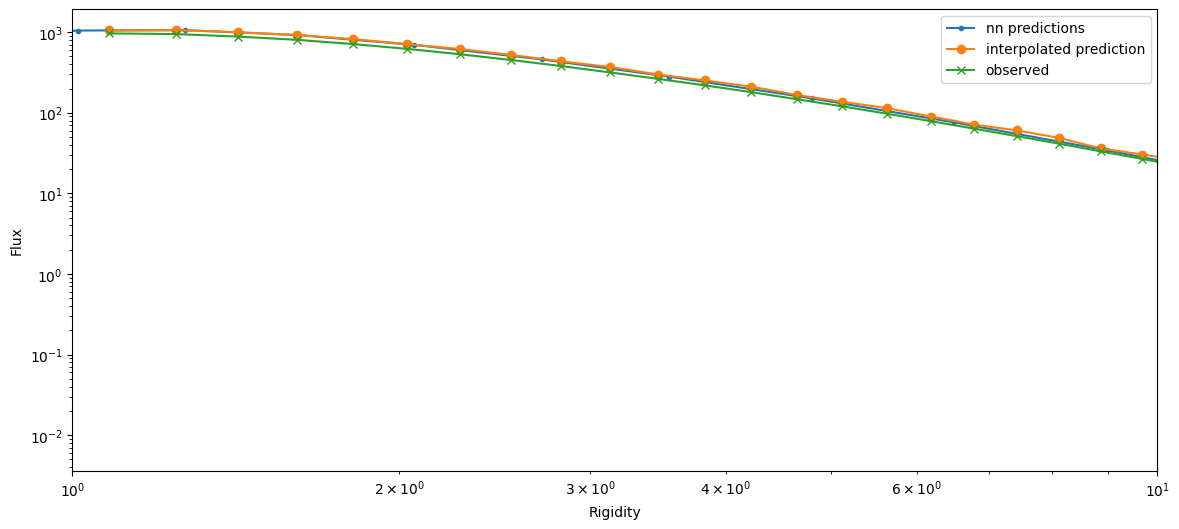

In [52]:
import matplotlib.pylab as plt
from utils import RIGIDITY_VALS

#xloc, iloc, observed, uncertainty = utils.load_preprocessed_data_ams(data_path)
bins, observed, uncertainty = utils.load_data_ams(data_path)
bin_midpoints = (bins[:-1] + bins[1:])/2
#bin_midpoints = (bins[:-1] * bins[1:]) ** 0.5

# iloc = np.searchsorted(RIGIDITY_VALS, bins)
# xloc = np.sort(np.concatenate([RIGIDITY_VALS, bins]))
# assert np.all(xloc[iloc] == bins)
xloc = np.concatenate([RIGIDITY_VALS, bins])
sorted_indices = np.argsort(xloc)
xloc = xloc[sorted_indices] # xloc is sorted list of rigidity locations.
iloc = np.where(sorted_indices>=len(RIGIDITY_VALS))[0]

parameters_specified_transformed = transform_input(jnp.array(specified_parameters).reshape((1,-1)))
samples_transformed = transform_input(jnp.array(samples)).reshape((-1))
batch = utils._form_batch(samples_transformed, parameters_specified_transformed)
#yhat = nn_predict(batch)

model = keras.models.load_model(model_path)
yhat = model(batch)    
yhat = utils.untransform_output(yhat) # Undo scaling and minmax.
yhat = yhat[0,:]  # Remove batch dimension.

predicted = jnp.interp(bin_midpoints, utils.RIGIDITY_VALS, yhat)
#chi2 = (((predicted - observed)/uncertainty)**2).sum()
#log_prob = -chi2/2.  - nlogprior

plt.figure(figsize=(14,6))
plt.loglog(RIGIDITY_VALS, yhat, marker='.', label='nn predictions')
#plt.loglog(xloc, yloc, marker='.', label='nn interpolated')
plt.loglog(bin_midpoints, predicted, marker='o', label='interpolated prediction')
plt.plot(bin_midpoints, observed, marker='x', label='observed')  #unnormalized?
plt.ylabel('Flux')
plt.xlabel('Rigidity')
plt.xlim([1, 10])
plt.legend()
iloc, bins

63 31 30 30


(array([15, 17, 19, 20, 22, 23, 25, 26, 27, 29, 30, 32, 33, 34, 36, 37, 38,
        39, 41, 42, 43, 45, 46, 47, 49, 50, 52, 54, 56, 58, 60]),
 array([  1.  ,   1.16,   1.33,   1.51,   1.71,   1.92,   2.15,   2.4 ,
          2.67,   2.97,   3.29,   3.64,   4.02,   4.43,   4.88,   5.37,
          5.9 ,   6.47,   7.09,   7.76,   8.48,   9.26,  10.1 ,  11.  ,
         13.  ,  16.6 ,  22.8 ,  33.5 ,  48.5 ,  69.7 , 100.  ]))

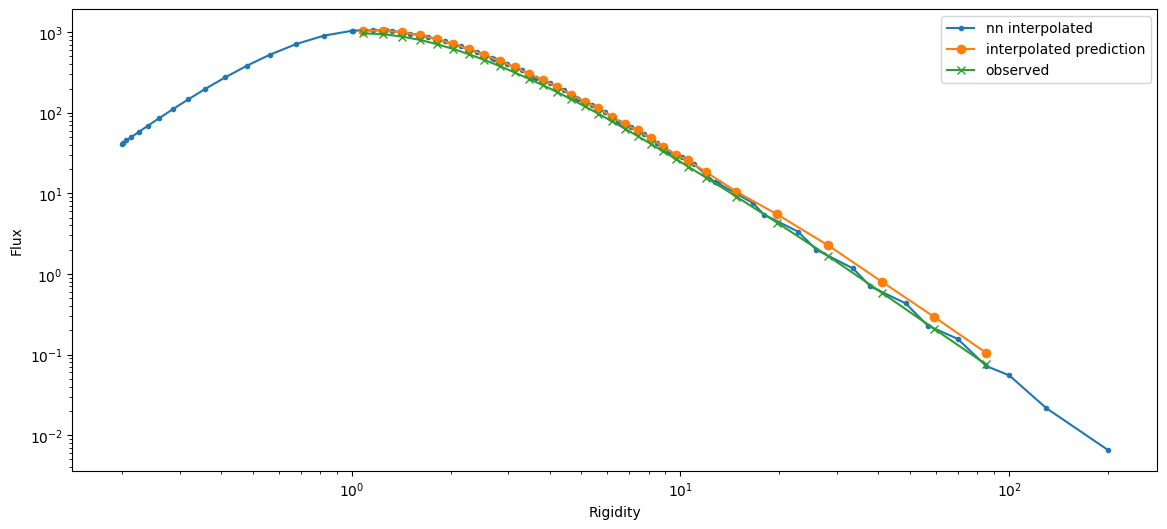

In [35]:
import matplotlib.pylab as plt
from utils import RIGIDITY_VALS

#xloc, iloc, observed, uncertainty = utils.load_preprocessed_data_ams(data_path)
bins, observed, uncertainty = utils.load_data_ams(data_path)
# iloc = np.searchsorted(RIGIDITY_VALS, bins)
# xloc = np.sort(np.concatenate([RIGIDITY_VALS, bins]))
# assert np.all(xloc[iloc] == bins)
xloc = np.concatenate([RIGIDITY_VALS, bins])
sorted_indices = np.argsort(xloc)
xloc = xloc[sorted_indices] # xloc is sorted list of rigidity locations.
iloc = np.where(sorted_indices>=len(RIGIDITY_VALS))[0]

parameters_specified_transformed = transform_input(jnp.array(specified_parameters).reshape((1,-1)))
samples_transformed = transform_input(jnp.array(samples)).reshape((-1))
batch = utils._form_batch(samples_transformed, parameters_specified_transformed)
#yhat = nn_predict(batch)

model = keras.models.load_model(model_path)
yhat = model(batch)    
yhat = utils.untransform_output(yhat) # Undo scaling and minmax.
yhat = yhat[0,:]  # Remove batch dimension.
yloc = jnp.interp(xloc, utils.RIGIDITY_VALS, yhat)

nbins = len(iloc)-1
predicted = np.zeros(nbins)
bin_midpoints = (xloc[iloc[:-1]] + xloc[iloc[1:]])/2
for i in range(nbins):
    # Integrate over bin by trapezoid method.
    #predicted[i] = yloc[iloc[i]]
    istart, istop = iloc[i], iloc[i+1]
    predicted[i] = (yloc[istart] + yloc[istop]) / 2
    #predicted[i] = (yloc[istart] * yloc[istop])**0.5
    # Use equation provided by Claudio for likelihood of bin.
    #chi2 += ((predicted - observed[i])
    #Integrate over bin by trapezoid method.
    # istart, istop = iloc[i], iloc[i+1]
    # area = jnp.trapz(y=yloc[istart:(istop+1)], x=xloc[istart:(istop+1)])
    # length = (xloc[istop] - xloc[istart])
    # predicted[i] = area / length



#yloc = jnp.interp(xloc, utils.RIGIDITY_VALS, yhat)
print(len(xloc), len(iloc), len(observed), len(uncertainty))

plt.figure(figsize=(14,6))
#plt.loglog(RIGIDITY_VALS, yhat, marker='.', label='nn predictions')
plt.loglog(xloc, yloc, marker='.', label='nn interpolated')
plt.plot(bin_midpoints, predicted, marker='o', label='interpolated prediction')
plt.plot(bin_midpoints, observed, marker='x', label='observed')  #unnormalized?
plt.ylabel('Flux')
plt.xlabel('Rigidity')
plt.legend()
iloc, bins

array([ 1.08 ,  1.245,  1.42 ,  1.61 ,  1.815,  2.035,  2.275,  2.535,
        2.82 ,  3.13 ,  3.465,  3.83 ,  4.225,  4.655,  5.125,  5.635,
        6.185,  6.78 ,  7.425,  8.12 ,  8.87 ,  9.68 , 10.55 , 12.   ,
       14.8  , 19.7  , 28.15 , 41.   , 59.1  , 84.85 ])